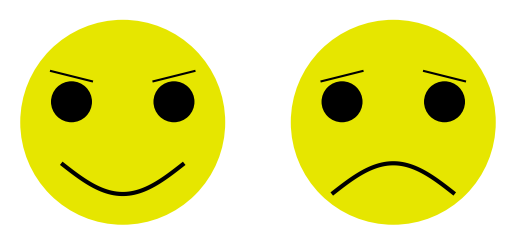

In [1]:
import matplotlib.pyplot as pp
import numpy as np
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

In [2]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return 0
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return 0
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return 2
  if 'frown' in face:
    return 1  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return 0

In [3]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return torch.tensor([i in face for i in sorted_keys]).float()

class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # We encoded the current state as binary vector, for each patch the associated
    # dimension is either 0 or 1 depending on the absence or precense of that patch.
    # Therefore the input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             # We also output 6 numbers, since there are up to
                             # 6 possible actions (and thus child states), but we
                             # will mask those outputs for patches that are
                             # already there.
                             nn.Linear(num_hid, 6))
  def forward(self, x):
    # We take the exponential to get positive numbers, since flows must be positive,
    # and multiply by (1 - x) to give 0 flow to actions we know we can't take
    # (in this case, x[i] is 1 if a feature is already there, so we know we
    # can't add it again).
    F = self.mlp(x).exp() * (1 - x)
    return F

In [4]:
def face_parents(state):
  parent_states = []  # states that are parents of state
  parent_actions = []  # actions that lead from those parents to state
  for face_part in state:
    # For each face part, there is a parent without that part
    parent_states.append([i for i in state if i != face_part])
    # The action to get there is the corresponding index of that face part
    parent_actions.append(sorted_keys.index(face_part))
  return parent_states, parent_actions

In [5]:
# Instantiate model and optimizer
F_sa = FlowModel(512)
opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict F(s, a)
  edge_flow_prediction = F_sa(face_to_tensor(state))
  for t in range(3):
    # The policy is just normalizing, and gives us the probability of each action
    policy = edge_flow_prediction / edge_flow_prediction.sum()
    # Sample the action
    action = Categorical(probs=policy).sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]

    # Now we want to compute the loss, we'll first enumerate the parents
    parent_states, parent_actions = face_parents(new_state)
    # And compute the edge flows F(s, a) of each parent
    px = torch.stack([face_to_tensor(p) for p in parent_states])
    pa = torch.tensor(parent_actions).long()
    parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
    # Now we need to compute the reward and F(s, a) of the current state,
    # which is currently `new_state`
    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = face_reward(new_state)
      # and since there are no children to this state F(s,a) = 0 \forall a
      edge_flow_prediction = torch.zeros(6)
    else:
      # Otherwise we keep going, and compute F(s, a)
      reward = 0
      edge_flow_prediction = F_sa(face_to_tensor(new_state))

    # The loss as per the equation above
    flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
    minibatch_loss += flow_mismatch  # Accumulate
    # Continue iterating
    state = new_state

  # We're done with the episode, add the face to the list, and if we are at an
  # update episode, take a gradient step.
  sampled_faces.append(state)
  if episode % update_freq == 0:
    losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0


100%|█| 50000/50000 [04:37<00:00, 180.38


Ratio of faces with a smile: 0.5859375
Ratio of valid faces: 0.9375


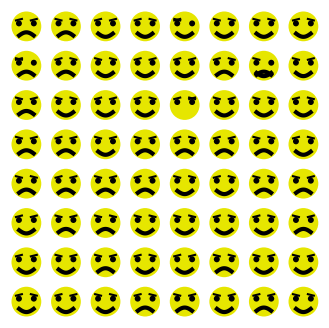

In [6]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

In [11]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # The input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             # We now output 12 numbers, 6 for P_F and 6 for P_B
                             nn.Linear(num_hid, 12))
    # log Z is just a single number
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    logits = self.mlp(x)
    # Slice the logits, and mask invalid actions (since we're predicting
    # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
    P_F = logits[..., :6] * (1 - x) + x * -100
    P_B = logits[..., 6:] * x + (1 - x) * -100
    return P_F, P_B

In [12]:
# Instantiate model and optimizer
model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

# Let's keep track of the losses and the faces we sample
tb_losses = []
tb_sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 2

logZs = []
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict P_F, P_B
  P_F_s, P_B_s = model(face_to_tensor(state))
  total_P_F = 0
  total_P_B = 0
  for t in range(3):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = torch.tensor(face_reward(new_state)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(face_to_tensor(new_state))
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy. I.e., for P_F action
    # `i` just added the face part `i`, for P_B we'll assume action `i` removes
    # face part `i`, this way we can just keep the same indices.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss

  # Add the face to the list, and if we are at an
  # update episode, take a gradient step.
  tb_sampled_faces.append(state)
  if episode % update_freq == 0:
    tb_losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs.append(model.logZ.item())


100%|█| 50000/50000 [05:30<00:00, 151.08


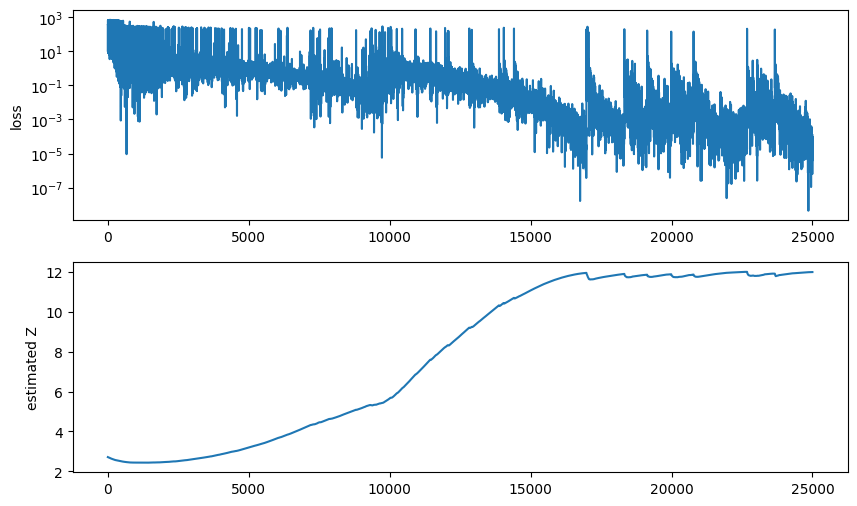

In [13]:
f, ax = pp.subplots(2, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')

In [14]:
model.logZ.exp()

tensor([11.9820], grad_fn=<ExpBackward0>)

Ratio of faces with a smile: 0.765625
Ratio of valid faces: 1.0


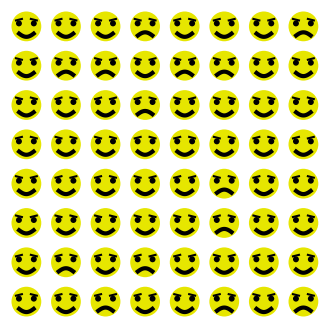

In [15]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in tb_sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in tb_sampled_faces[-128:]]) / 128)
for i, face in enumerate(tb_sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)